In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import root
from quantecon import MarkovChain

C:\Users\Tom\AppData\Roaming\Python\Python37\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


This notebook refactorizes the code for solving the sequential allocation problems in the [quantecon lecture](https://python-advanced.quantecon.org/opt_tax_recur.html). The code is improved in mainly three aspects:

1. readability: improve the consistency between the code and the math in the lecture
    1. math notations of model parameters and variables
    2. the computation is now closely following the "computational algorithm" described in the lecture
2. efficiency: reducing the dimension of root finding when solving FOCs
    1. change the root to find from $\left[c, n, \Xi\right]$ to just $\left[ c \right]$
    2. remove the redundant computations that are actually not used in the lecture
3. minor issues: make the design of Python classes more reasonable
    1. moving the attributes $\pi$ and $g$ from class `CRRAutility` to `SequentialAllocation` since the government expenditure and the state transition matrix is irrelevant with the preference, but are characteristics of the sequential allocation problems.

In the following, I will present:

1. the original code and the refactorized code
2. a section that verifies the refactorized code by replications
    1. verify that the quantities given by the original and refactorized code are the same
    2. verify that we can generate the same figure as in the lecture using the refactorized code
    3. verify that the solutions to a bunch of randomly generated sequential allocation problems given by two verisons of code are identical
2. a section demonstrates the improvement in speed
    1. the speed is improved by almost 20 to 30 percent

Note that I will rename the original Python classes by adding a suffix `Old` and reserve the concise names for the refactorized classes.

# Original Code

A "copy and paste" from the current [quantecon lecture](https://python-advanced.quantecon.org/opt_tax_recur.html).

In [2]:
class SequentialAllocationOld:

    '''
    Class that takes CESutility or BGPutility object as input returns
    planner's allocation as a function of the multiplier on the
    implementability constraint μ.
    '''

    def __init__(self, model):

        # Initialize from model object attributes
        self.β, self.π, self.G = model.β, model.π, model.G
        self.mc, self.Θ = MarkovChain(self.π), model.Θ
        self.S = len(model.π)  # Number of states
        self.model = model

        # Find the first best allocation
        self.find_first_best()

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        model = self.model
        S, Θ, G = self.S, self.Θ, self.G
        Uc, Un = model.Uc, model.Un

        def res(z):
            c = z[:S]
            n = z[S:]
            return np.hstack([Θ * Uc(c, n) + Un(c, n), Θ * n - c - G])

        res = root(res, 0.5 * np.ones(2 * S))

        if not res.success:
            raise Exception('Could not find first best')

        self.cFB = res.x[:S]
        self.nFB = res.x[S:]

        # Multiplier on the resource constraint
        self.ΞFB = Uc(self.cFB, self.nFB)
        self.zFB = np.hstack([self.cFB, self.nFB, self.ΞFB])

    def time1_allocation(self, μ):
        '''
        Computes optimal allocation for time t >= 1 for a given μ
        '''
        model = self.model
        S, Θ, G = self.S, self.Θ, self.G
        Uc, Ucc, Un, Unn = model.Uc, model.Ucc, model.Un, model.Unn

        def FOC(z):
            c = z[:S]
            n = z[S:2 * S]
            Ξ = z[2 * S:]
            # FOC of c
            return np.hstack([Uc(c, n) - μ * (Ucc(c, n) * c + Uc(c, n)) - Ξ,
                              Un(c, n) - μ * (Unn(c, n) * n + Un(c, n)) \
                              + Θ * Ξ,  # FOC of n
                              Θ * n - c - G])

        # Find the root of the first-order condition
        res = root(FOC, self.zFB)
        if not res.success:
            raise Exception('Could not find LS allocation.')
        z = res.x
        c, n, Ξ = z[:S], z[S:2 * S], z[2 * S:]

        # Compute x
        I = Uc(c, n) * c + Un(c, n) * n
        x = np.linalg.solve(np.eye(S) - self.β * self.π, I)

        return c, n, x, Ξ

    def time0_allocation(self, B_, s_0):
        '''
        Finds the optimal allocation given initial government debt B_ and
        state s_0
        '''
        model, π, Θ, G, β = self.model, self.π, self.Θ, self.G, self.β
        Uc, Ucc, Un, Unn = model.Uc, model.Ucc, model.Un, model.Unn

        # First order conditions of planner's problem
        def FOC(z):
            μ, c, n, Ξ = z
            xprime = self.time1_allocation(μ)[2]
            return np.hstack([Uc(c, n) * (c - B_) + Un(c, n) * n + β * π[s_0]
                                            @ xprime,
                              Uc(c, n) - μ * (Ucc(c, n)
                                            * (c - B_) + Uc(c, n)) - Ξ,
                              Un(c, n) - μ * (Unn(c, n) * n
                                            + Un(c, n)) + Θ[s_0] * Ξ,
                              (Θ * n - c - G)[s_0]])

        # Find root
        res = root(FOC, np.array(
            [0, self.cFB[s_0], self.nFB[s_0], self.ΞFB[s_0]]))
        if not res.success:
            raise Exception('Could not find time 0 LS allocation.')

        return res.x

    def time1_value(self, μ):
        '''
        Find the value associated with multiplier μ
        '''
        c, n, x, Ξ = self.time1_allocation(μ)
        U = self.model.U(c, n)
        V = np.linalg.solve(np.eye(self.S) - self.β * self.π, U)
        return c, n, x, V

    def Τ(self, c, n):
        '''
        Computes Τ given c, n
        '''
        model = self.model
        Uc, Un = model.Uc(c, n), model.Un(c,  n)

        return 1 + Un / (self.Θ * Uc)

    def simulate(self, B_, s_0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        model, π, β = self.model, self.π, self.β
        Uc = model.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s_0)

        cHist, nHist, Bhist, ΤHist, μHist = np.zeros((5, T))
        RHist = np.zeros(T - 1)

        # Time 0
        μ, cHist[0], nHist[0], _ = self.time0_allocation(B_, s_0)
        ΤHist[0] = self.Τ(cHist[0], nHist[0])[s_0]
        Bhist[0] = B_
        μHist[0] = μ

        # Time 1 onward
        for t in range(1, T):
            c, n, x, Ξ = self.time1_allocation(μ)
            Τ = self.Τ(c, n)
            u_c = Uc(c, n)
            s = sHist[t]
            Eu_c = π[sHist[t - 1]] @ u_c
            cHist[t], nHist[t], Bhist[t], ΤHist[t] = c[s], n[s], x[s] / u_c[s], \
                                                     Τ[s]
            RHist[t - 1] = Uc(cHist[t - 1], nHist[t - 1]) / (β * Eu_c)
            μHist[t] = μ

        return np.array([cHist, nHist, Bhist, ΤHist, sHist, μHist, RHist])

In [3]:
class CRRAutilityOld:

    def __init__(self,
                 β=0.9,
                 σ=2,
                 γ=2,
                 π=0.5*np.ones((2, 2)),
                 G=np.array([0.1, 0.2]),
                 Θ=np.ones(2),
                 transfers=False):

        self.β, self.σ, self.γ = β, σ, γ
        self.π, self.G, self.Θ, self.transfers = π, G, Θ, transfers

    # Utility function
    def U(self, c, n):
        σ = self.σ
        if σ == 1.:
            U = np.log(c)
        else:
            U = (c**(1 - σ) - 1) / (1 - σ)
        return U - n**(1 + self.γ) / (1 + self.γ)

    # Derivatives of utility function
    def Uc(self, c, n):
        return c**(-self.σ)

    def Ucc(self, c, n):
        return -self.σ * c**(-self.σ - 1)

    def Un(self, c, n):
        return -n**self.γ

    def Unn(self, c, n):
        return -self.γ * n**(self.γ - 1)

# Refactorization

In [4]:
class SequentialAllocation:

    '''
    Class that takes CESutility or BGPutility object as input returns
    planner's allocation as a function of the multiplier on the
    implementability constraint μ.
    '''

    def __init__(self,
                 pref,
                 π=0.5*np.ones((2, 2)),
                 g=np.array([0.1, 0.2])):

        # Initialize from pref object attributes
        self.β, self.π, self.g = pref.β, π, g
        self.mc = MarkovChain(self.π)
        self.S = len(π)  # Number of states
        self.pref = pref

        # Find the first best allocation
        self.find_first_best()

    def FOC_first_best(self, c, g):

        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        n = c + g
        l = 1 - n

        return Uc(c, l) - Ul(c, l)

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        S, g = self.S, self.g

        res = root(self.FOC_first_best, 0.5 * np.ones(S), args=(g,))

        if not res.success:
            raise Exception('Could not find first best')

        self.cFB = res.x
        self.nFB = self.cFB + g

    def FOC_time1(self, c, Φ, g):

        pref = self.pref
        Uc, Ucc, Ul, Ull, Ulc = pref.Uc, pref.Ucc, pref.Ul, pref.Ull, pref.Ulc

        n = c + g
        l = 1 - n

        LHS = (1 + Φ) * Uc(c, l) + Φ * (c * Ucc(c, l) - n * Ulc(c, l))
        RHS = (1 + Φ) * Ul(c, l) + Φ * (c * Ulc(c, l) - n * Ull(c, l))

        diff = LHS - RHS

        return diff

    def time1_allocation(self, Φ):
        '''
        Computes optimal allocation for time t >= 1 for a given μ
        '''
        pref = self.pref
        S, g = self.S, self.g

        res = root(self.FOC_time1, self.cFB, args=(Φ, g))

        if not res.success:
            raise Exception('Could not find LS allocation.')

        c = res.x
        n = c + g
        l = 1 - n

        # Compute x
        I = pref.Uc(c, n) * c - pref.Ul(c, l) * n
        x = np.linalg.solve(np.eye(S) - self.β * self.π, I)

        return c, n, x

    def FOC_time0(self, c0, Φ, g0, b0):

        pref = self.pref
        Ucc, Ulc = pref.Ucc, pref.Ulc

        n0 = c0 + g0
        l0 = 1 - n0

        diff = self.FOC_time1(c0, Φ, g0)
        diff -= Φ * (Ucc(c0, l0) - Ulc(c0, l0)) * b0

        return diff

    def implementability(self, Φ, b0, s0, cn0_arr):

        pref, π, g, β = self.pref, self.π, self.g, self.β
        Uc, Ul = pref.Uc, pref.Ul
        g0 = self.g[s0]

        c, n, x = self.time1_allocation(Φ)

        res = root(self.FOC_time0, cn0_arr[0], args=(Φ, g0, b0))
        c0 = res.x
        n0 = c0 + g0
        l0 = 1 - n0

        cn0_arr[:] = c0, n0

        LHS = Uc(c0, l0) * b0
        RHS = Uc(c0, l0) * c0 - Ul(c0, l0) * n0 + β * π[s0] @ x

        return RHS - LHS

    def time0_allocation(self, b0, s0):
        '''
        Finds the optimal allocation given initial government debt B_ and
        state s_0
        '''

        cn0_arr = np.array([self.cFB[s0], self.nFB[s0]])

        res = root(self.implementability, 0, args=(b0, s0, cn0_arr))

        if not res.success:
            raise Exception('Could not find time 0 LS allocation.')

        Φ = res.x[0]
        c0, n0 = cn0_arr

        return Φ, c0, n0

    def time1_value(self, μ):
        '''
        Find the value associated with multiplier μ
        '''
        c, n, x = self.time1_allocation(μ)
        U = self.pref.U(c, n)
        V = np.linalg.solve(np.eye(self.S) - self.β * self.π, U)
        return c, n, x, V

    def τ(self, c, n):
        '''
        Computes τ given c, n
        '''
        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        return 1 - Ul(c, 1-n) / Uc(c, 1-n)

    def simulate(self, b0, s0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        pref, π, β = self.pref, self.π, self.β
        Uc = pref.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s0)

        cHist, nHist, Bhist, τHist, ΦHist = np.zeros((5, T))
        RHist = np.zeros(T - 1)

        # Time 0
        Φ, cHist[0], nHist[0] = self.time0_allocation(b0, s0)
        τHist[0] = self.τ(cHist[0], nHist[0])
        Bhist[0] = b0
        ΦHist[0] = Φ

        # Time 1 onward
        for t in range(1, T):
            c, n, x = self.time1_allocation(Φ)
            τ = self.τ(c, n)
            u_c = Uc(c, n)
            s = sHist[t]
            Eu_c = π[sHist[t - 1]] @ u_c
            cHist[t], nHist[t], Bhist[t], τHist[t] = c[s], n[s], x[s] / u_c[s], τ[s]
            RHist[t - 1] = Uc(cHist[t - 1], nHist[t - 1]) / (β * Eu_c)
            ΦHist[t] = Φ

        return np.array([cHist, nHist, Bhist, τHist, sHist, ΦHist, RHist])

In [5]:
class CRRAutility:

    def __init__(self,
                 β=0.9,
                 σ=2,
                 γ=2):

        self.β, self.σ, self.γ = β, σ, γ

        # the correspondence between the general LS notations and the CRRA notations
        self.Uc = lambda c, l: self._Uc(c, 1-l)
        self.Ucc = lambda c, l: self._Ucc(c, 1-l)
        self.Ulc = lambda c, l: 0
        self.Ul = lambda c, l: - self._Un(c, 1-l)
        self.Ull = lambda c, l: self._Unn(c, 1-l)

    # Utility function
    def U(self, c, n):
        σ = self.σ
        if σ == 1.:
            U = np.log(c)
        else:
            U = (c**(1 - σ) - 1) / (1 - σ)
        return U - n**(1 + self.γ) / (1 + self.γ)

    # Derivatives of utility function
    def _Uc(self, c, n):
        return c**(-self.σ)

    def _Ucc(self, c, n):
        return -self.σ * c**(-self.σ - 1)

    def _Un(self, c, n):
        return -n**self.γ

    def _Unn(self, c, n):
        return -self.γ * n**(self.γ - 1)

## Verify by replicating

Set the model parameters.

In [6]:
time_π = np.array([[0, 1, 0,   0,   0,  0],
                   [0, 0, 1,   0,   0,  0],
                   [0, 0, 0, 0.5, 0.5,  0],
                   [0, 0, 0,   0,   0,  1],
                   [0, 0, 0,   0,   0,  1],
                   [0, 0, 0,   0,   0,  1]])

time_G = np.array([0.1, 0.1, 0.1, 0.2, 0.1, 0.1])
# Θ can in principle be random
time_Θ = np.ones(6)

In [7]:
b0, s0 = 1, 0

Construct an old `SequentialAllocation` instance and compute the equilibrium quantities.

In [8]:
time_example_old = CRRAutilityOld(π=time_π, G=time_G, Θ=time_Θ)
time_allocation_old = SequentialAllocationOld(time_example_old)

In [9]:
cFB_old, nFB_old = time_allocation_old.cFB, time_allocation_old.nFB

In [10]:
μ_old, c0_old, n0_old, _ = time_allocation_old.time0_allocation(b0, s0)

In [11]:
c1_old, n1_old, x1_old, _ = time_allocation_old.time1_allocation(μ_old)

Construct a `SequentialAllocation` instance using the refactorized code and compute the equilibrium quantities.

In [12]:
preference = CRRAutility()
time_allocation = SequentialAllocation(preference, π=time_π, g=time_G)

In [13]:
cFB, nFB = time_allocation.cFB, time_allocation_old.nFB

In [14]:
Φ, c0, n0 = time_allocation.time0_allocation(b0, s0)

In [15]:
c1, n1, x1 = time_allocation.time1_allocation(Φ)

Compare the quantities returned by the old and refactorized code and verify the differences are close to $0$.

In [16]:
for z_old, z in zip([cFB_old, nFB_old, c0_old, n0_old, c1_old, n1_old, x1_old],
                    [cFB, nFB, c0, n0, c1, n1, x1]):

    print(np.max(np.abs(z_old - z)))

6.661338147750939e-16
0.0
1.844080443902385e-12
1.844080443902385e-12
2.1327384303049257e-13
2.1327384303049257e-13
8.995026945513018e-12


Remark: Note that the sign of the Lagrange multiplier $\Phi$ is flipped so that it is consistent with the math in the lecture.

In [17]:
μ_old

-0.06175628493986698

In [18]:
Φ

0.06175628494006926

In [19]:
μ_old + Φ

2.0228263508670352e-13

The final step of "verifying by replicating" is to generate the same plot we have in the [quantecon lecture](https://python-advanced.quantecon.org/opt_tax_recur.html#Anticipated-One-Period-War).

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


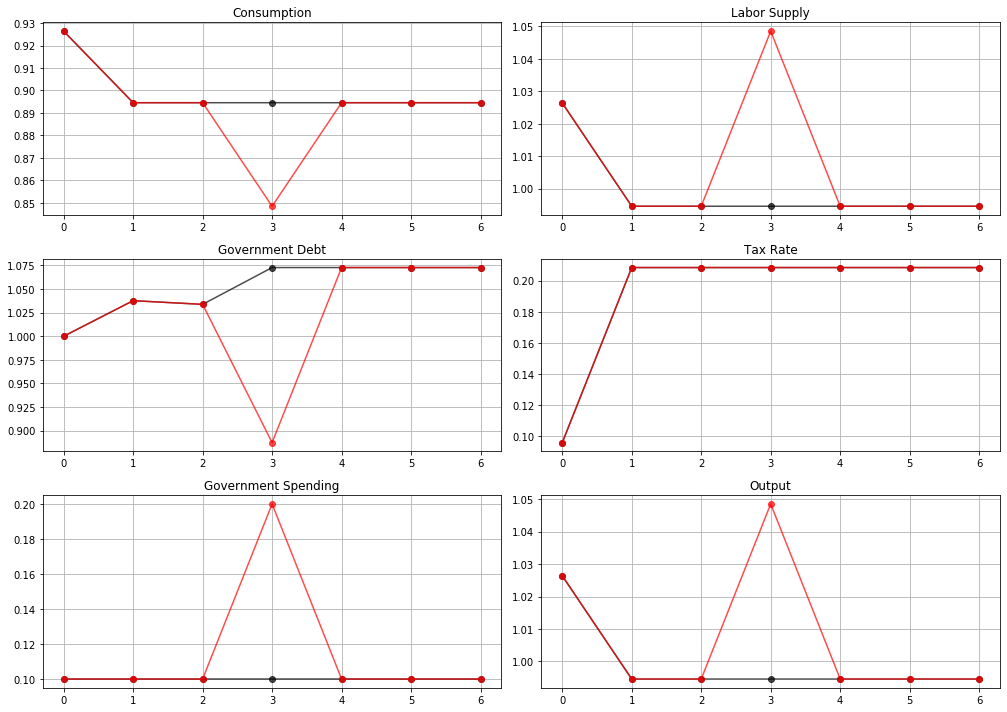

In [20]:
# Solve sequential problem
sHist_h = np.array([0, 1, 2, 3, 5, 5, 5])
sHist_l = np.array([0, 1, 2, 4, 5, 5, 5])
sim_seq_h = time_allocation.simulate(1, 0, 7, sHist_h)
sim_seq_l = time_allocation.simulate(1, 0, 7, sHist_l)

# Government spending paths
sim_seq_l[4] = time_allocation.g[sHist_l]
sim_seq_h[4] = time_allocation.g[sHist_h]

# Output paths
sim_seq_l[5] = sim_seq_l[1]
sim_seq_h[5] = sim_seq_h[1]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']

for ax, title, sim_l, sim_h in zip(axes.flatten(),
        titles, sim_seq_l, sim_seq_h):
    ax.set(title=title)
    ax.plot(sim_l, '-ok', sim_h, '-or', alpha=0.7)
    ax.grid()

plt.tight_layout()
plt.show()

Finally, let's generate a bunch of random model parameters $\pi$ and $g$, as well as random initial state $s_0$ and intial debt $b_0$, and verify that the refactorized code returns the same equilibrium quantities as the original code.

In [21]:
N = 1000
res = np.ones(N, dtype=bool)

S_max = 7
for i in range(N):

    # generate a random LS problem
    S = np.random.randint(1, S_max)

    b0 = np.random.random()
    s0 = np.random.randint(0, S)

    time_π = np.random.random((S, S))
    time_π = (time_π.T / time_π.sum(1)).T

    time_G = np.random.random(S) * 0.2

    time_Θ = np.ones(S)

    # solution given by the original code
    time_example_old = CRRAutilityOld(π=time_π, G=time_G, Θ=time_Θ)
    time_allocation_old = SequentialAllocationOld(time_example_old)

    cFB_old, nFB_old = time_allocation_old.cFB, time_allocation_old.nFB
    μ_old, c0_old, n0_old, _ = time_allocation_old.time0_allocation(b0, s0)
    c1_old, n1_old, x1_old, _ = time_allocation_old.time1_allocation(μ_old)

    # solution given by the refactorized code
    preference = CRRAutility()
    time_allocation = SequentialAllocation(preference, π=time_π, g=time_G)

    cFB, nFB = time_allocation.cFB, time_allocation_old.nFB
    Φ, c0, n0 = time_allocation.time0_allocation(b0, s0)
    c1, n1, x1 = time_allocation.time1_allocation(Φ)

    # compare
    for z_old, z in zip([cFB_old, nFB_old, c0_old, n0_old, c1_old, n1_old, x1_old],
                    [cFB, nFB, c0, n0, c1, n1, x1]):

        if np.max(np.abs(z_old - z)) > 1e-8:
            res[i] = False
            continue

In [22]:
if res.all():
    print("test passed")
else:
    print("replication failed")

test passed


## Speed Comparison

By refactorizing the code, the speed is improved by almost 20 to 30 percent on Tom's PHBS machine. I suspect the main improvement comes from the reduction in the dimension of the root to find, from expanded vector $\left[c, n, \Xi\right]$ to just $\left[c\right]$.

In [23]:
%timeit time_allocation_old.time0_allocation(1, 0)

7.51 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit time_allocation.time0_allocation(1, 0)

5.85 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
